In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import sqlite3
import sqlalchemy
from party_news.partykeywords import filter_party_names_json
from party_news.common_crawl import get_unprocessed_s3_keys
import json
import plotly.express as px
from pathlib import Path
from tqdm.auto import tqdm
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
tqdm.pandas()

In [11]:
color_discrete_map = {
    'SPD': "#E3000F",
    'CDU': "#32302e",
    'CSU': "#0080c8",
    'Bündnis 90/Die Grünen': "#46962b",
    'AfD': "#009ee0",
    'DIE LINKE': "#df0404",
    'FDP': "#ffed00",
    'Olaf Scholz': "#E3000F",
    'Annalena Baerbock': "#46962b",
    'Armin Laschet': "#32302e"
}

In [12]:
engine = sqlalchemy.create_engine("sqlite:///resources/database.sqlite")

In [13]:
df = pd.read_sql("SELECT WARC_Date, WARC_Target_URI, registered_domain, tld_suffix, article_title, article_summary FROM warcrecordmodel", engine, parse_dates=["WARC_Date"])
df = df.drop_duplicates("WARC_Target_URI")
df = df.drop_duplicates(["article_title", "registered_domain"])

In [14]:
short_names = [
    'AfD',
    'DIE LINKE',
    'Bündnis 90/Die Grünen',
    'FDP',
    'CSU',
    'CDU',
    'SPD'
]

In [15]:
def search_for_mentionings_of_parties(text, party_names):
    parties = filter_party_names_json(path="resources/party_names.json", short_party_names_list=short_names)
    search_results = {}
    parties_mentioned = []
    for party in parties:
        party_names = {party["full_name"], party["label"], party["short_name"]}.union(set(party["other_names"]))
        party_names = {x for x in party_names}
        for name in party_names:
            if name in text:
                parties_mentioned.append(party["full_name"])
                break
    return parties_mentioned

In [16]:
df["parties_mentioned"] = df["article_summary"].progress_apply(lambda x: search_for_mentionings_of_parties(x, short_names))
df = df[df["parties_mentioned"].apply(len) > 0]
exploded = df.explode("parties_mentioned")
exploded = exploded[exploded["parties_mentioned"].notna()]

  0%|          | 0/77208 [00:00<?, ?it/s]

# Outlets

'https://plotly.com/~thimm/8/'

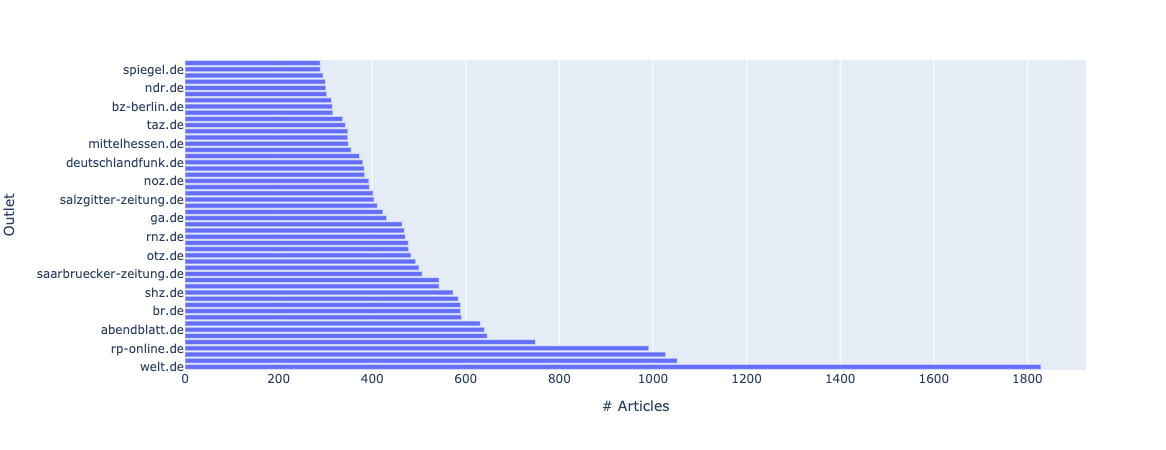

In [17]:
fig = px.bar(
    df["registered_domain"].value_counts().head(50).reset_index().rename({"registered_domain": "# Articles", "index": "Outlet"}, axis=1),
    y="Outlet", x="# Articles", orientation="h")
py.plot(fig, filename="Most occuring domains", auto_open=False)
fig

# Total mentions

'https://plotly.com/~thimm/6/'

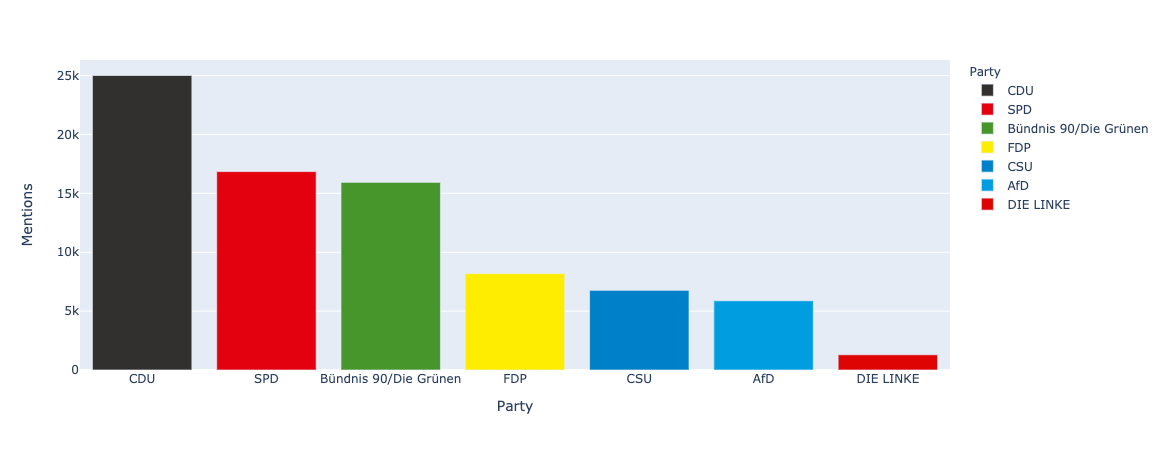

In [18]:
total_mentions = exploded["parties_mentioned"].value_counts().reset_index()
total_mentions.columns = ["Party", "Mentions"]

fig = px.bar(total_mentions, color="Party", x="Party", y="Mentions", color_discrete_map=color_discrete_map)
py.plot(fig, filename="Total Mentions of political parties", auto_open=False)
fig

## Most mentioned in outlets (Treemap)

In [19]:
most_mentioned = (
    exploded
    .groupby(["registered_domain"])["parties_mentioned"]
    .apply(lambda x: pd.value_counts(x))
    .reset_index()
    .drop_duplicates(subset=["registered_domain"])
    .merge(
        exploded.groupby(["registered_domain"])["parties_mentioned"].count().reset_index(),
        on="registered_domain"
    )
)
most_mentioned.columns = ["Domain", "Most mentioned", "Mentions Party",  "Total mentions"]
most_mentioned = most_mentioned[most_mentioned["Total mentions"] > 30]

'https://plotly.com/~thimm/37/'

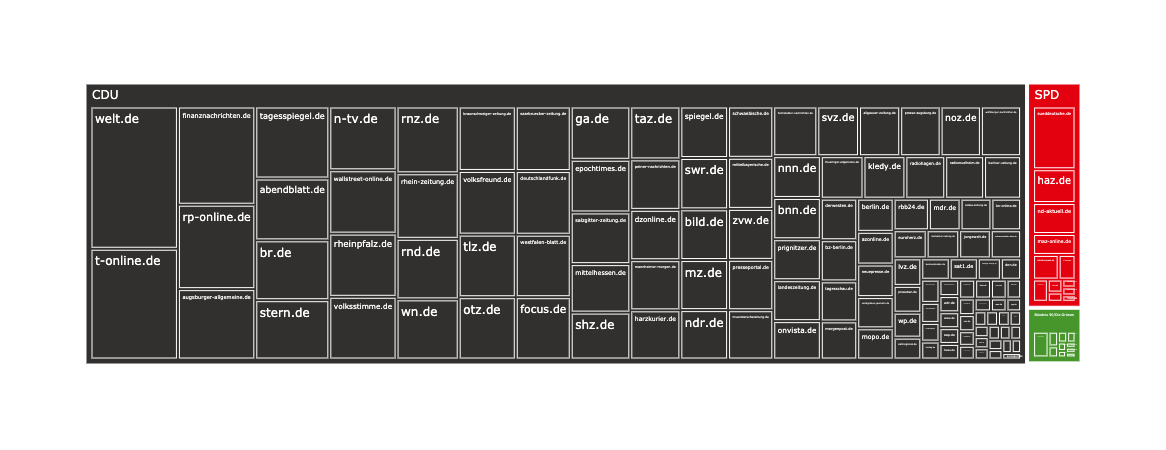

In [20]:
fig = px.treemap(most_mentioned, path=["Most mentioned", "Domain"], values="Total mentions",
                  color="Most mentioned", hover_data=["Domain", "Most mentioned", "Mentions Party",  "Total mentions"],
                 color_discrete_map=color_discrete_map
                 )
py.plot(fig, filename="Most mentiond party for each Domain", auto_open=False)

fig

# Mentions over time

In [21]:
mentions_over_time = (
    exploded
    .groupby(
        [
            pd.Grouper(key="WARC_Date", freq="d"), 
            "parties_mentioned"
        ]
    )["WARC_Target_URI"]
    .count()
    .reset_index()
)
mentions_over_time.columns = ["Date", "Party", "Mentions"]

'https://plotly.com/~thimm/12/'

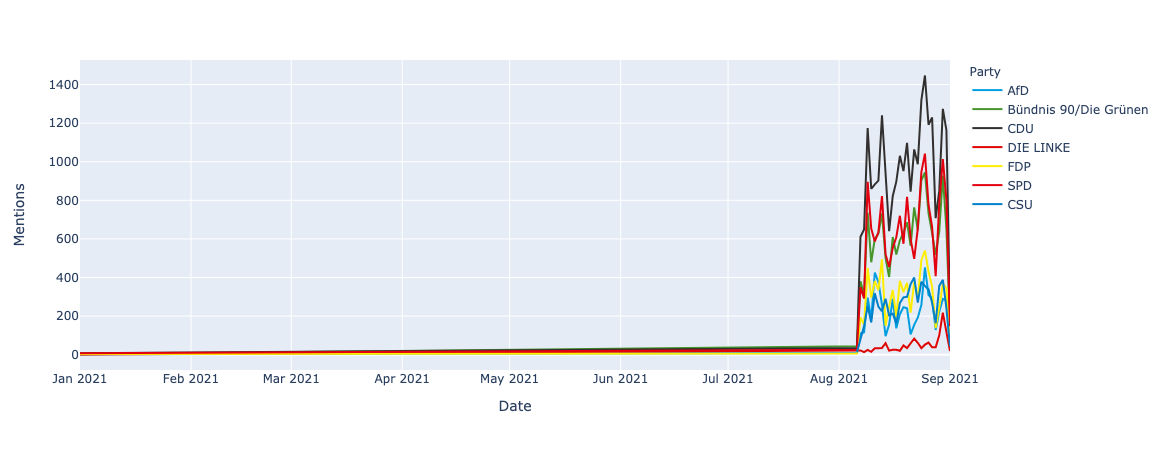

In [22]:
fig = px.line(mentions_over_time, x="Date", y="Mentions", color="Party", color_discrete_map=color_discrete_map, line_group="Party")

py.plot(fig, filename="Mentions of political parties over time", auto_open=False)
fig

# Mentions of parties by domain name

'https://plotly.com/~thimm/14/'

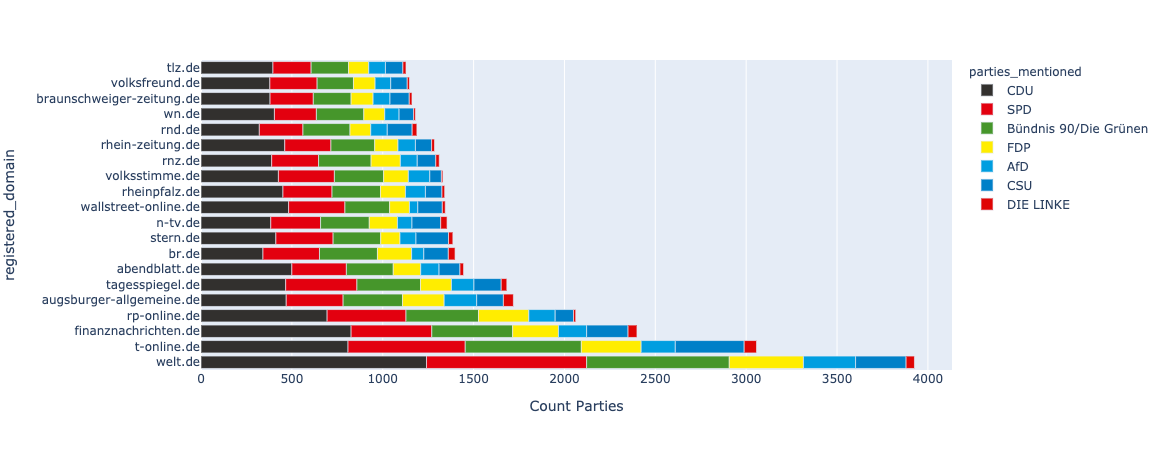

In [23]:
parties_mentioned_domain = pd.DataFrame(exploded.groupby(["registered_domain"])["parties_mentioned"].value_counts())
parties_mentioned_domain.columns = ["Count Parties"]
parties_mentioned_domain = parties_mentioned_domain.reset_index()
parties_mentioned_domain = parties_mentioned_domain.merge(parties_mentioned_domain.groupby("registered_domain").sum().reset_index(), on="registered_domain")

parties_mentioned_domain.columns = ["registered_domain", "parties_mentioned", "Count Parties", "Count Newspaper"]

most_mentions = (
    parties_mentioned_domain
    .drop_duplicates(["registered_domain", "Count Newspaper"])
    .sort_values("Count Newspaper")["registered_domain"]
    .tail(20)
)
parties_mentioned_domain = (
    parties_mentioned_domain[parties_mentioned_domain["registered_domain"].isin(most_mentions)]
    .sort_values(["Count Newspaper", "Count Parties"], ascending=False)
)

fig = px.bar(parties_mentioned_domain, y="registered_domain", x="Count Parties", color="parties_mentioned",
       orientation="h", hover_name="parties_mentioned", color_discrete_map=color_discrete_map
      )

py.plot(fig, filename="Mentions of parties by domain name", auto_open=False)
fig


# Mentions candidate names

In [24]:
names = {
    "Olaf Scholz": ["Olaf Scholz", "Scholz"],
    "Annalena Baerbock": ["Annalena Baerbock", "Baerbock"],
    "Armin Laschet": ["Armin Laschet", "Laschet"]
}
def search_for_mentionings_of_names(text, names):
    search_results = {}
    names_mentioned = []
    for full_name, name_variations in names.items():
        for name in name_variations:
            if name in text:
                names_mentioned.append(full_name)
                break
    return list(set(names_mentioned))

In [25]:
df["names_mentioned"] = df["article_summary"].apply(lambda x: search_for_mentionings_of_names(x, names))
exploded_names = df[df["names_mentioned"].apply(len) > 0].explode("names_mentioned")
exploded_names = exploded_names[exploded_names["names_mentioned"].notna()]



'https://plotly.com/~thimm/27/'

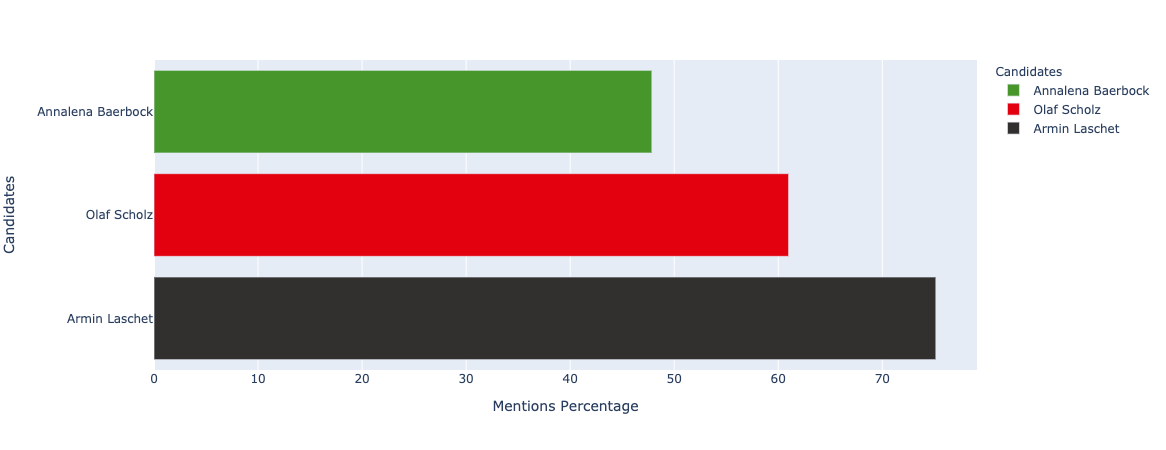

In [26]:
exploded_names_value_count = exploded_names.groupby(["registered_domain"])["names_mentioned"].value_counts(normalize=False)
exploded_names_value_count.index.names = ['Domain', 'Candidates']
exploded_names_value_count = exploded_names_value_count.reset_index()
exploded_names_value_count = exploded_names_value_count.merge(
    exploded_names.groupby(["registered_domain"])["WARC_Date"].count().reset_index().rename({"registered_domain": "Domain", "WARC_Date": "Total Articles"}, axis=1),
    on="Domain"
)
exploded_names_value_count["Mentions Percentage"] = exploded_names_value_count["names_mentioned"] / exploded_names_value_count["Total Articles"]


fig = px.bar(
    exploded_names_value_count.groupby("Candidates").sum().reset_index().sort_values("Mentions Percentage"), 
    x="Mentions Percentage", 
    y="Candidates", 
    color="Candidates", 
    color_discrete_map=color_discrete_map, orientation="h")

py.plot(fig, filename="Candidates mentioned in news articles (%)", auto_open=False)
fig

'https://plotly.com/~thimm/18/'

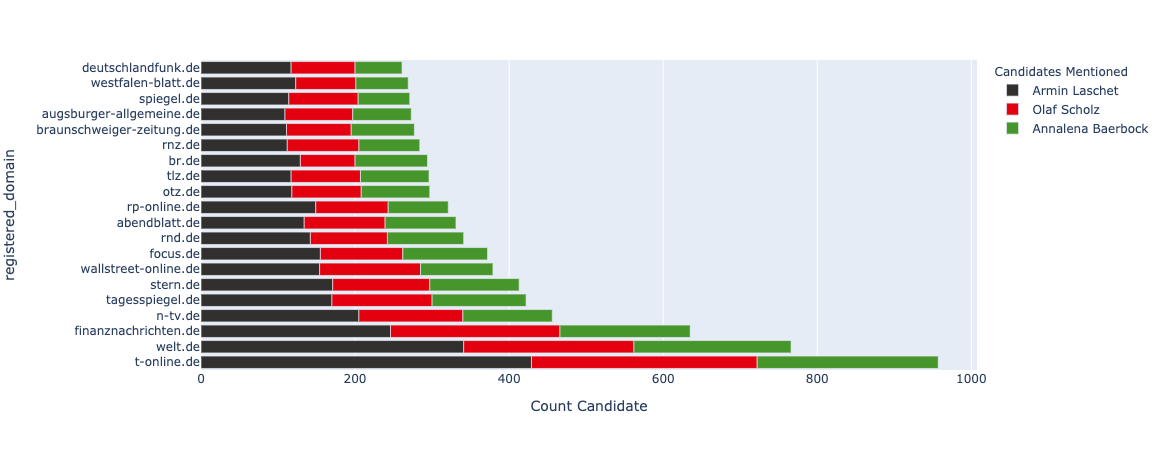

In [27]:
candidate_mentioned_domain = pd.DataFrame(exploded_names.groupby(["registered_domain"])["names_mentioned"].value_counts())
candidate_mentioned_domain.columns = ["Count Candidate"]
candidate_mentioned_domain = candidate_mentioned_domain.reset_index()
candidate_mentioned_domain = candidate_mentioned_domain.merge(candidate_mentioned_domain.groupby("registered_domain").sum().reset_index(), on="registered_domain")

candidate_mentioned_domain.columns = ["registered_domain", "Candidates Mentioned", "Count Candidate", "Count Newspaper"]

most_mentions = (
    candidate_mentioned_domain
    .drop_duplicates(["registered_domain", "Count Newspaper"])
    .sort_values("Count Newspaper")["registered_domain"]
    .tail(20)
)
candidate_mentioned_domain = (
    candidate_mentioned_domain[candidate_mentioned_domain["registered_domain"].isin(most_mentions)]
    .sort_values(["Count Newspaper", "Count Candidate"], ascending=False)
)
candidate_mentioned_domain["Count Candidate %"] = round(candidate_mentioned_domain["Count Candidate"] / candidate_mentioned_domain["Count Newspaper"] * 100)

fig = px.bar(candidate_mentioned_domain, y="registered_domain", x="Count Candidate", color="Candidates Mentioned",
       orientation="h", hover_name="Candidates Mentioned", color_discrete_map=color_discrete_map
      )
py.plot(fig, filename="Candidates mentioned in news outlets", auto_open=False)
fig

# Mentions over time

'https://plotly.com/~thimm/20/'

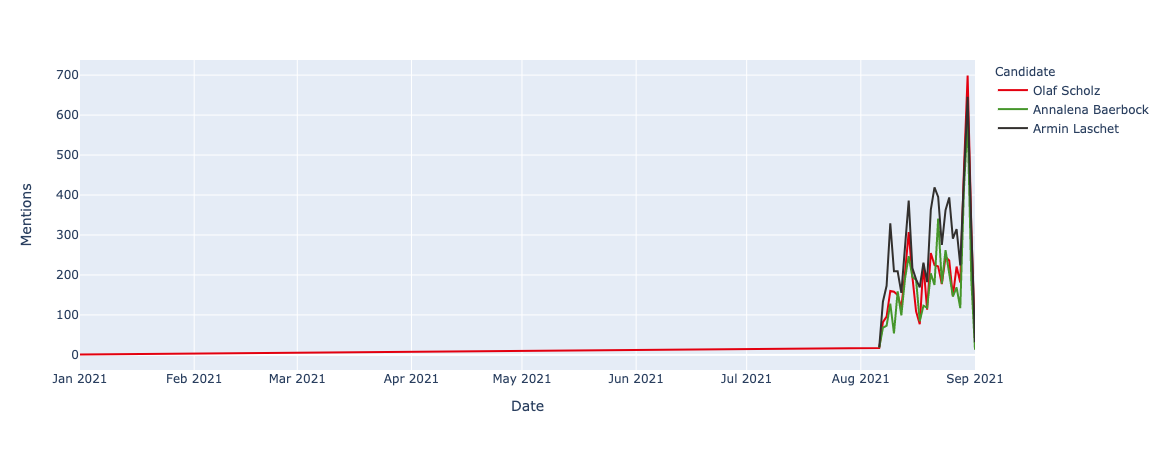

In [28]:
candidates_over_time = (
    exploded_names
    .groupby(
        [pd.Grouper(key="WARC_Date", freq="d"), "names_mentioned"])["WARC_Target_URI"]
    .count()
    .reset_index()
)
candidates_over_time.columns = ["Date", "Candidate", "Mentions"]
fig = px.line(candidates_over_time, x="Date", y="Mentions", line_group="Candidate", color="Candidate", color_discrete_map=color_discrete_map)
py.plot(fig, filename="Candidates mentions over time", auto_open=False)
fig

# News outlets that are the most unequal

'https://plotly.com/~thimm/22/'

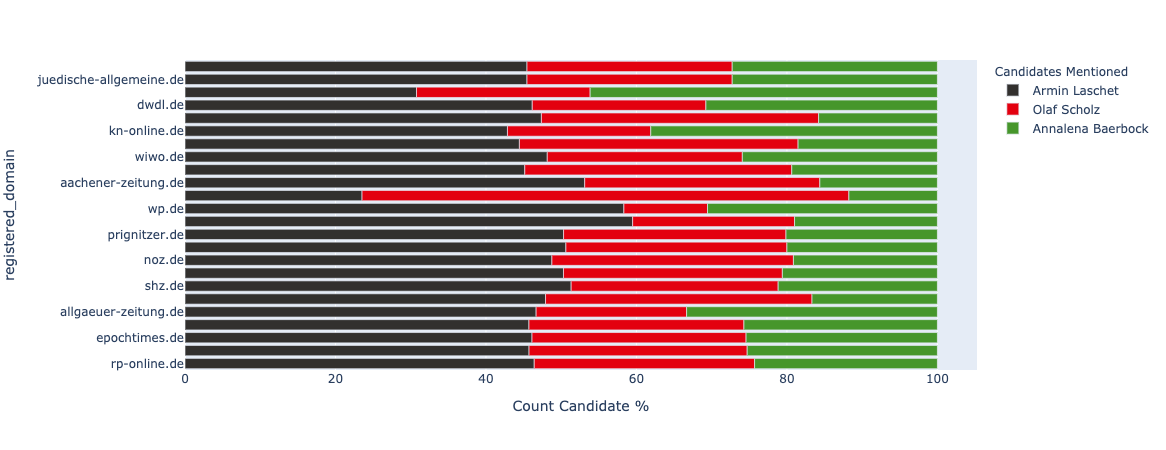

In [29]:
candidate_mentioned_domain = pd.DataFrame(exploded_names.groupby(["registered_domain"])["names_mentioned"].value_counts())
candidate_mentioned_domain.columns = ["Count Candidate"]
candidate_mentioned_domain = candidate_mentioned_domain.reset_index()
candidate_mentioned_domain = candidate_mentioned_domain.merge(candidate_mentioned_domain.groupby("registered_domain").sum().reset_index(), on="registered_domain")

candidate_mentioned_domain.columns = ["registered_domain", "Candidates Mentioned", "Count Candidate", "Count Newspaper"]

most_mentions = (
    candidate_mentioned_domain
    .drop_duplicates(["registered_domain", "Count Newspaper"])
    .sort_values("Count Newspaper")["registered_domain"]
)
candidate_mentioned_domain = (
    candidate_mentioned_domain[candidate_mentioned_domain["registered_domain"].isin(most_mentions)]
    .sort_values(["Count Newspaper", "Count Candidate"], ascending=False)
)
candidate_mentioned_domain["Count Candidate %"] = candidate_mentioned_domain["Count Candidate"] / candidate_mentioned_domain["Count Newspaper"] * 100


unequal = candidate_mentioned_domain[
    ( (candidate_mentioned_domain["Count Candidate %"] >= 45) & (candidate_mentioned_domain["Count Candidate %"] < 50) ) | 
    ( (candidate_mentioned_domain["Count Candidate %"] <= 22) & (candidate_mentioned_domain["Count Candidate %"] > 0) ) &
    (candidate_mentioned_domain["Count Newspaper"] > 20)
]["registered_domain"].unique()
fig = px.bar(candidate_mentioned_domain[candidate_mentioned_domain["registered_domain"].isin(unequal)], y="registered_domain", x="Count Candidate %", color="Candidates Mentioned",
       orientation="h", hover_name="Candidates Mentioned", color_discrete_map=color_discrete_map
      )

py.plot(fig, filename="Most unequal mentions", auto_open=False)
fig

'https://plotly.com/~thimm/22/'

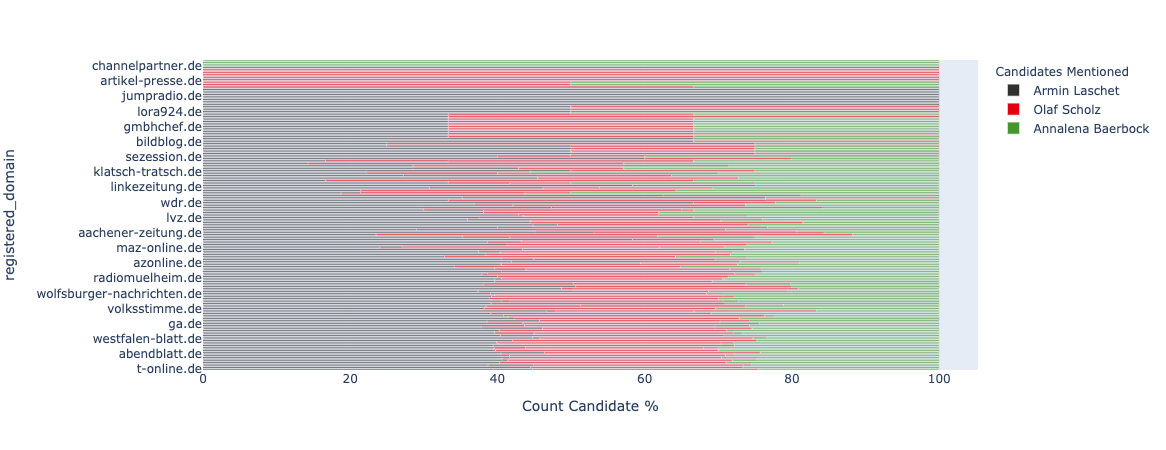

In [30]:
unequal = candidate_mentioned_domain["registered_domain"].unique()
fig = px.bar(candidate_mentioned_domain[candidate_mentioned_domain["registered_domain"].isin(unequal)], y="registered_domain", x="Count Candidate %", color="Candidates Mentioned",
       orientation="h", hover_name="Candidates Mentioned", color_discrete_map=color_discrete_map
      )

py.plot(fig, filename="Most unequal mentions", auto_open=False)
fig